In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import json
from ipywidgets import interact, interactive, fixed, RadioButtons
import ipywidgets as widgets
from IPython.display import display
import pathlib
p = pathlib.Path('../data/shutoushu-nodenum_600_seed_34567.csv')

In [13]:
with open(p, newline='', encoding='utf_8_sig') as f:
    reader = csv.DictReader(f)
    logs = [row for row in reader]
    

dest_list = [log.get('destination_id') for log in logs]   
dest_list = set(dest_list)
print(dest_list) #destination Id を重複なしでリストに保存

{' 287', ' 309', ' 145', ' 104', ' 447', ' 101', ' 132', ' 277', ' 63', ' 426', ' 278', ' 146', ' 176', ' 402', ' 239', ' 334', ' 398', ' 411', ' 131'}


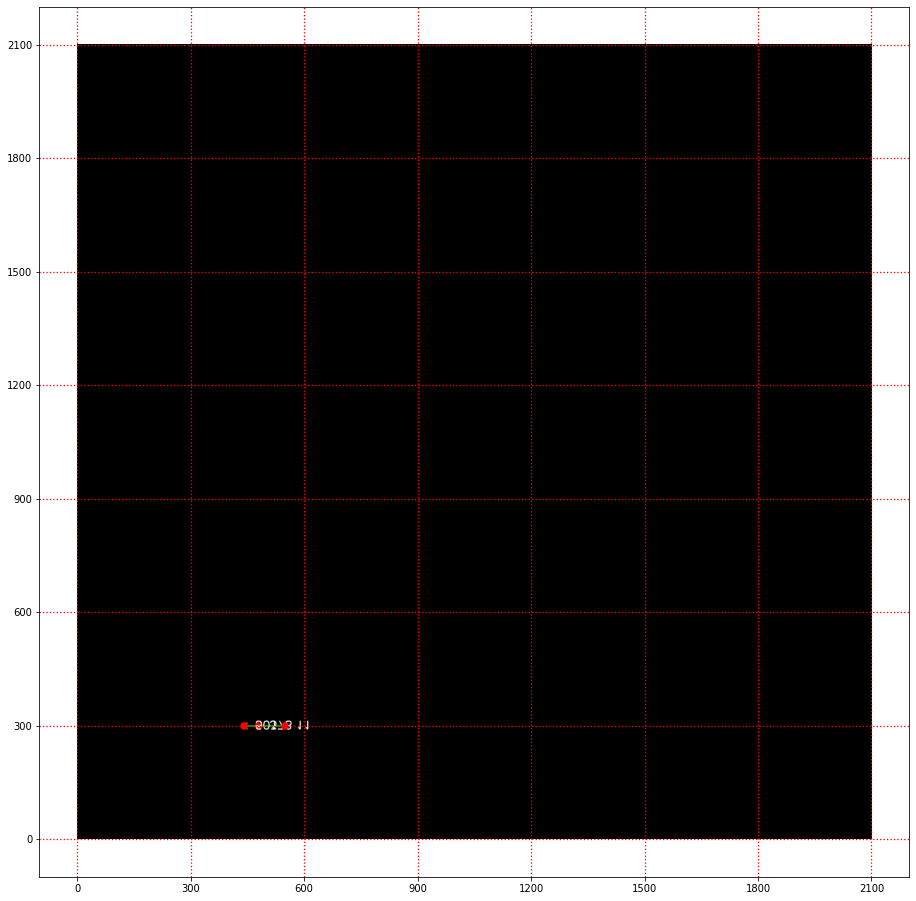

In [14]:
img_area = np.zeros(shape=(2100,2100, 3), dtype=np.int16)
img_area.shape


#packetの軌跡を描画 
@interact(minHop=(1, 14,1), maxHop=(2, 15, 1), desId=dest_list)
def packetDraw(desId, minHop, maxHop):
    img_area = np.zeros(shape=(2100,2100, 3), dtype=np.int16)
    count = 1
    for log in logs:
        if log['destination_id'] == desId:
#         if log['destination_id'] == desId and int(log['hopcount']) > minHop and int(log['hopcount']) < maxHop:
            cv2.arrowedLine(img_area,(int(log['source_x']), int(log['source_y'])), 
                            (int(log['recv_x']), int(log['recv_y'])), (0, 255, 0), thickness=2)
            cv2.circle(img=img_area, center=(int(log['source_x']),
                                   int(log['source_y'])), radius=10, color=(255,0,0), thickness=-1)
            cv2.circle(img=img_area, center=(int(log['recv_x']),
                                   int(log['recv_y'])), radius=10, color=(255,0,0), thickness=-1)
            cv2.putText(img_area, log['source_id'], (int(log['source_x']) + 13,
                                   int(log['source_y']) +13 ), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), thickness=2)
            cv2.putText(img_area, log['recv_id'], (int(log['recv_x']) + 13,
                                   int(log['recv_y']) +13), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), thickness=2)
            if count == 1:
                plt.figure(figsize=(16, 16))
                plt.grid(color='r', linestyle='dotted', linewidth=1.3)
                plt.xlim([-100, 2200])
#                 plt.xticks([0,300,600,900,1200,1500,1800,2100]) 
                plt.xticks([2100,1800,1500,1200,900,600,300, 0]) 
                plt.ylim([-100, 2200])
                plt.yticks([0,300,600,900,1200,1500,1800,2100])  #メモリの間隔を指定 
                            
#             plt.imshow(img_area, extent=(0,2100,0,2100))
            plt.imshow(img_area)
            count = count +1